In [ ]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("ananthu017/emotion-detection-fer")

print("Path to dataset files:", path)


100%|██████████| 65.2M/65.2M [00:00<00:00, 116MB/s]

Extracting files...


Path to dataset files: /root/.cache/kagglehub/datasets/ananthu017/emotion-detection-fer/versions/1


In [ ]:
!kaggle datasets download -d ananthu017/emotion-detection-fer


Dataset URL: https://www.kaggle.com/datasets/ananthu017/emotion-detection-fer
License(s): CC0-1.0
 77% 50.0M/65.2M [00:00<00:00, 263MB/s]
100% 65.2M/65.2M [00:00<00:00, 265MB/s]


In [ ]:
from helper_functions import unzip_data,walk_through_dir

unzip_data("/content/emotion-detection-fer.zip")

In [ ]:
walk_through_dir("/content/train")

There are 7 directories and 0 images in '/content/train'.
There are 0 directories and 3171 images in '/content/train/surprised'.
There are 0 directories and 4965 images in '/content/train/neutral'.
There are 0 directories and 7215 images in '/content/train/happy'.
There are 0 directories and 4830 images in '/content/train/sad'.
There are 0 directories and 4097 images in '/content/train/fearful'.
There are 0 directories and 436 images in '/content/train/disgusted'.
There are 0 directories and 3995 images in '/content/train/angry'.


In [ ]:
walk_through_dir("/content/test")

There are 7 directories and 0 images in '/content/test'.
There are 0 directories and 831 images in '/content/test/surprised'.
There are 0 directories and 1233 images in '/content/test/neutral'.
There are 0 directories and 1774 images in '/content/test/happy'.
There are 0 directories and 1247 images in '/content/test/sad'.
There are 0 directories and 1024 images in '/content/test/fearful'.
There are 0 directories and 111 images in '/content/test/disgusted'.
There are 0 directories and 958 images in '/content/test/angry'.


In [ ]:
from tensorflow.keras.preprocessing import image_dataset_from_directory
train_dir = "/content/train"
test_dir = "/content/test"
IMG_SIZE = (224, 224)
train_data = image_dataset_from_directory(train_dir,label_mode='categorical',image_size=(IMG_SIZE),color_mode='grayscale')
test_data = image_dataset_from_directory(test_dir,label_mode='categorical',image_size=(IMG_SIZE),color_mode='grayscale',shuffle=False)

Found 28709 files belonging to 7 classes.
Found 7178 files belonging to 7 classes.


In [12]:
from tensorflow import keras
from tensorflow.keras import layers
data_augmentation = keras.Sequential([
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.2),
    layers.RandomZoom(0.2),
], name="data_augmentation")


(1, 48, 48)
(48, 48)


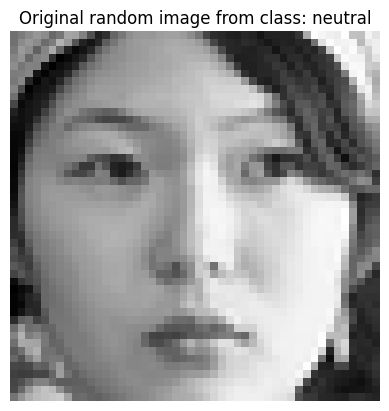

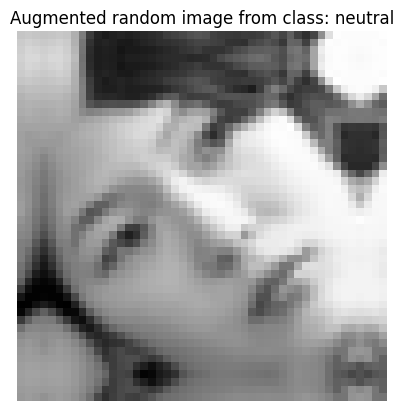

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import os
import random
import tensorflow as tf
target_class = random.choice(train_data.class_names) # choose a random class
target_dir = "/content/train/" + target_class # create the target directory
random_image = random.choice(os.listdir(target_dir)) # choose a random image from target directory
random_image_path = target_dir + "/" + random_image # create the choosen random image path
img = mpimg.imread(random_image_path) # read in the chosen target image
plt.imshow(img, cmap='gray') # plot the target image
plt.title(f"Original random image from class: {target_class}")
plt.axis(False); # turn off the axes
print(tf.expand_dims(img, axis=0).shape
)
# Augment the image
augmented_img = data_augmentation(tf.expand_dims(img, axis=0)) # data augmentation model requires shape (None, height, width, 3)
print(tf.squeeze(augmented_img).shape)
plt.figure()
plt.imshow(tf.squeeze(augmented_img), cmap='gray') # requires normalization after augmentation
plt.title(f"Augmented random image from class: {target_class}")
plt.axis(False);


In [ ]:
import tensorflow as tf

lr_scheduler = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_accuracy', factor=0.5, patience=5, verbose=1)
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=5, restore_best_weights=True)

In [ ]:
from tensorflow.keras.optimizers import AdamW

input_shape = (224, 224, 1)
base_model = tf.keras.applications.EfficientNetV2B3(include_top=False)
base_model.trainable = True

for layer in base_model.layers[:-30]:
  layer.trainable = False
inputs = layers.Input(shape=input_shape, name="input_layer")
x = data_augmentation(inputs) # augment our training images
x = base_model(inputs, training=False)
x = layers.GlobalAveragePooling2D(name="pooling_layer")(x)
x = layers.Dropout(0.5)(x)  # Add dropout to reduce overfitting
x = layers.Dense(256, activation="relu")(x)
x = layers.Dropout(0.3)(x)  # Add another dropout layer
x = layers.Dense(len(train_data.class_names))(x)
outputs = layers.Activation("softmax", dtype=tf.float32, name="softmax_float32")(x)
model= tf.keras.Model(inputs, outputs)
optimizer = AdamW(learning_rate=1e-4, weight_decay=1e-4)
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

history = model.fit(x=train_data,
    epochs=25,
    validation_data=test_data,
    steps_per_epoch=len(train_data),
    validation_steps=int(0.25 *len(test_data)),
    callbacks=[early_stopping, lr_scheduler])

Epoch 1/25
221/221 ━━━━━━━━━━━━━━━━━━━━ 193s 401ms/step - accuracy: 0.3272 - loss: 1.6353 - val_accuracy: 0.2606 - val_loss: 1.6684 - learning_rate: 1.0000e-04
Epoch 2/25
221/221 ━━━━━━━━━━━━━━━━━━━━ 58s 261ms/step - accuracy: 0.4976 - loss: 1.3042 - val_accuracy: 0.3242 - val_loss: 1.5167 - learning_rate: 1.0000e-04
Epoch 3/25
221/221 ━━━━━━━━━━━━━━━━━━━━ 82s 261ms/step - accuracy: 0.5343 - loss: 1.2057 - val_accuracy: 0.3733 - val_loss: 1.4341 - learning_rate: 1.0000e-04
Epoch 4/25
221/221 ━━━━━━━━━━━━━━━━━━━━ 82s 261ms/step - accuracy: 0.5608 - loss: 1.1411 - val_accuracy: 0.3945 - val_loss: 1.3729 - learning_rate: 1.0000e-04
Epoch 5/25
221/221 ━━━━━━━━━━━━━━━━━━━━ 82s 259ms/step - accuracy: 0.5780 - loss: 1.0977 - val_accuracy: 0.4252 - val_loss: 1.3464 - learning_rate: 1.0000e-04
Epoch 6/25
221/221 ━━━━━━━━━━━━━━━━━━━━ 82s 370ms/step - accuracy: 0.5980 - loss: 1.0582 - val_accuracy: 0.4252 - val_loss: 1.3277 - learning_rate: 1.0000e-04
Epoch 7/25
221/221 ━━━━━━━━━━━━━━━━━━━━ 58s 2

In [ ]:
test_data = image_dataset_from_directory(test_dir,label_mode='categorical',image_size=(IMG_SIZE),color_mode="grayscale",shuffle=False)

Found 7067 files belonging to 6 classes.


In [ ]:
model.evaluate(test_data)

221/221 ━━━━━━━━━━━━━━━━━━━━ 19s 84ms/step - accuracy: 0.6228 - loss: 0.9768


[0.8784686326980591, 0.6694495677947998]

In [ ]:
from helper_functions import make_confusion_matrix,pred_and_plot,plot_loss_curves

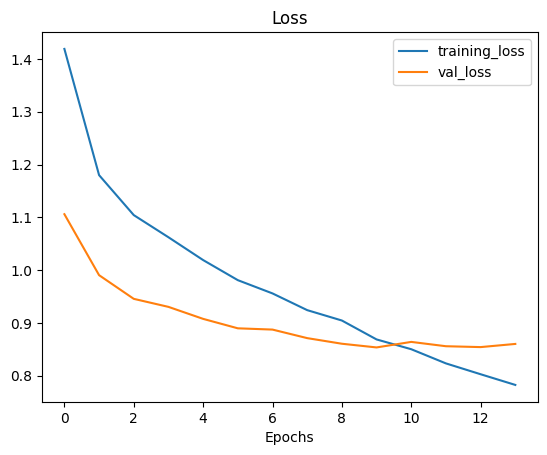

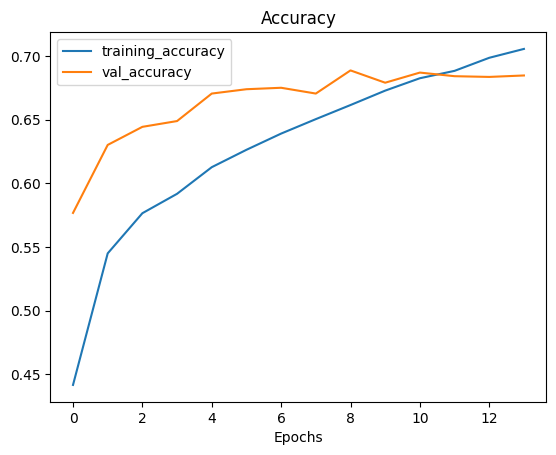

In [ ]:
plot_loss_curves(history)

In [ ]:
y_pred = model.predict(test_data)

221/221 ━━━━━━━━━━━━━━━━━━━━ 35s 122ms/step


In [ ]:
y_labels = []
for images, labels in test_data.unbatch(): # unbatch the test data and get images and labels
  y_labels.append(labels.numpy().argmax()) # append the index which has the largest value (labels are one-hot)
y_labels[:10] # check what they look like (unshuffled)

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0]

In [ ]:
pred_classes = y_pred.argmax(axis=1)

# How do they look?
pred_classes[:10]

array([0, 4, 3, 0, 0, 0, 0, 0, 0, 0])

In [ ]:
from sklearn.metrics import accuracy_score
sklearn_accuracy = accuracy_score(y_labels, pred_classes)
sklearn_accuracy


0.6694495542663081

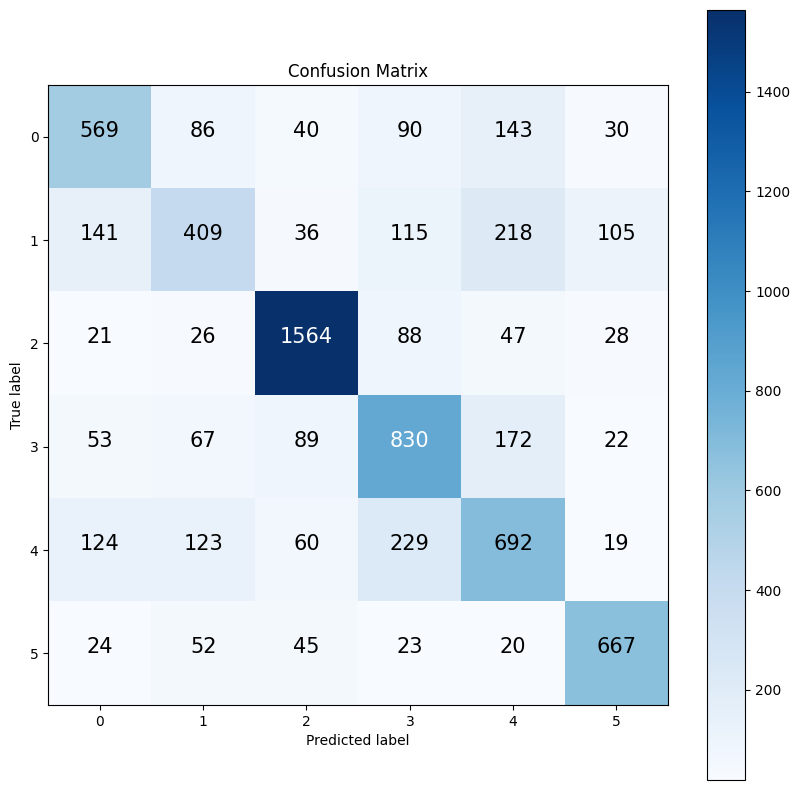

In [ ]:
make_confusion_matrix(y_labels, pred_classes)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step


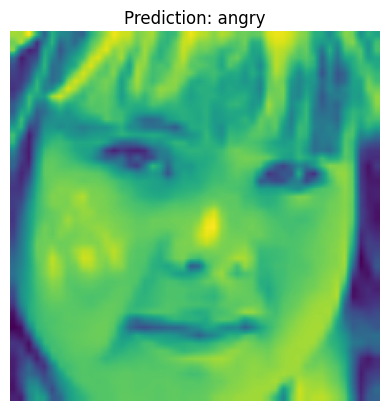

In [ ]:
from helper_functions import pred_and_plot
pred_and_plot(model, "/content/archive/test/neutral/im0.png", train_data.class_names)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step


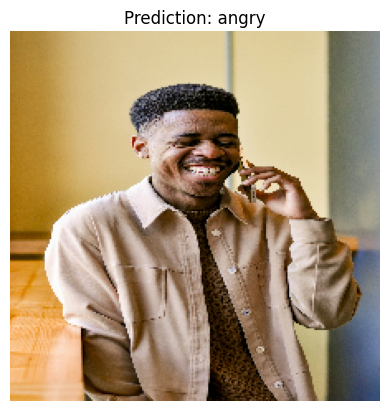

In [ ]:
pred_and_plot(model, "/content/sincerely-media-dxnEyQszbUo-unsplash (1).jpg", train_data.class_names)


In [ ]:
from google.colab import files
import shutil
model.save("model.h5")
shutil.make_archive("model", 'zip', ".", "model.h5")
files.download("model.zip")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
!apt-get -qq install -y libsm6 libxext6 && pip install -q -U opencv-python


In [34]:
faceCascade = cv2.CascadeClassifier(cv2.data.haarcascades + "haarcascade_frontalface_default.xml")

In [41]:
import numpy as np
import cv2
import tensorflow as tf
import matplotlib.pyplot as plt

# Load the face detection model
faceCascade = cv2.CascadeClassifier(cv2.data.haarcascades + "haarcascade_frontalface_default.xml")

def cut_and_predict_image(img, model, train_data):
    if not isinstance(img, str):
        print("Error: img_path must be a string but got", type(img))
        return

    fram = cv2.imread(img)

    if fram is None:
        print("Error: Image could not be loaded. Check the file path.")
        return

    grey = cv2.cvtColor(fram, cv2.COLOR_BGR2GRAY)
    faces = faceCascade.detectMultiScale(grey, 1.1, 4)

    if len(faces) == 0:
        print("No faces detected.")
        return

    for (x, y, w, h) in faces:
        roi_color = fram[y:y+h, x:x+w]
        cv2.rectangle(fram, (x, y), (x+w, y+h), (255, 0, 0), 2)

        # Convert ROI to grayscale before processing
        face_grey = cv2.cvtColor(roi_color, cv2.COLOR_BGR2GRAY)

        # Resize and preprocess the image
        final_image = cv2.resize(face_grey, (224, 224))
        final_image = np.expand_dims(final_image, axis=-1)  # Add channel dimension for grayscale
        final_image = np.expand_dims(final_image, axis=0)   # Expand batch dimension
        final_image = final_image / 255.0  # Normalize

        # Predict the class
        pred = model.predict(final_image)
        pred_class = train_data.class_names[int(tf.round(pred)[0][0])]

        # Display result
        plt.title(f"Prediction: {pred_class}")
        plt.imshow(tf.squeeze(final_image), cmap='gray')  # Display grayscale
        plt.axis(False)
        plt.show()


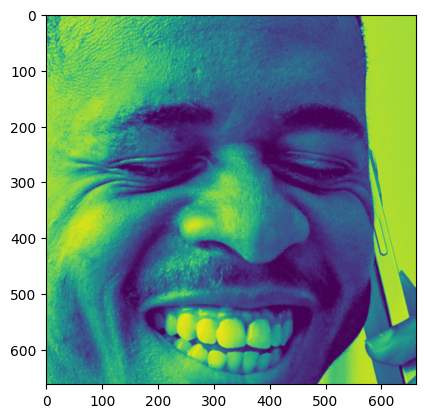

In [ ]:

plt.imshow(cv2.cvtColor(face_roi,cv2.COLOR_BGR2GRAY))

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step


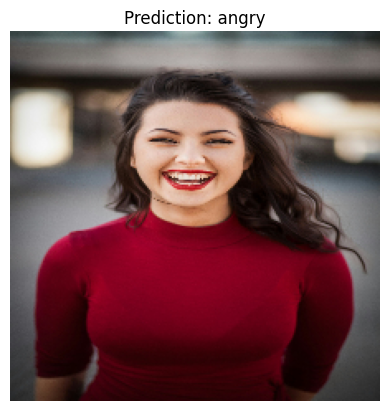

In [ ]:
from helper_functions import pred_and_plot
pred_and_plot(last_model,"/content/michael-dam-mEZ3PoFGs_k-unsplash.jpg",train_data.class_names)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 106ms/step


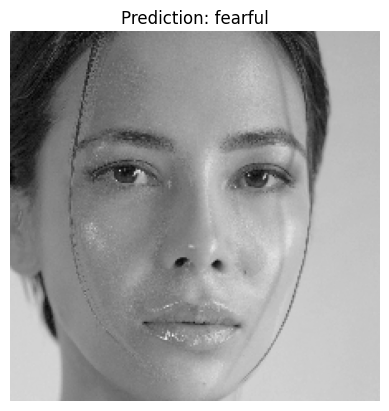

In [ ]:
cut_and_predict_image("/content/aiony-haust-3TLl_97HNJo-unsplash.jpg",last_model,train_data)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


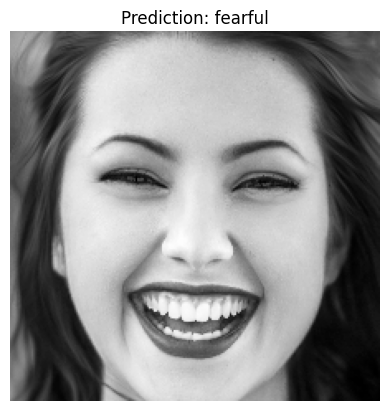

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


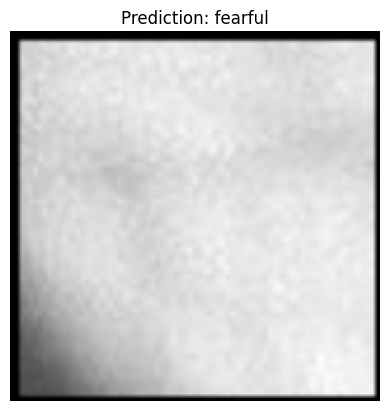

In [ ]:
cut_and_predict_image("/content/michael-dam-mEZ3PoFGs_k-unsplash.jpg",last_model,train_data)

1/1 ━━━━━━━━━━━━━━━━━━━━ 10s 10s/step


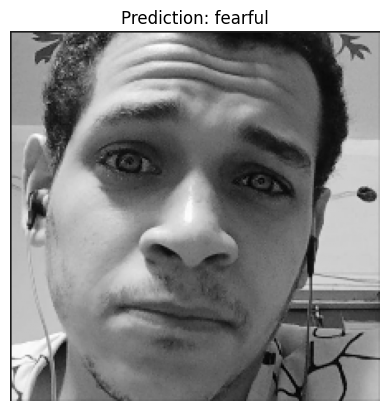

In [ ]:
cut_and_predict_image("/content/WhatsApp Image 2025-03-17 at 04.26.59.jpeg",last_model,train_data)

In [ ]:
last_model = tf.keras.models.load_model('model.h5')
last_model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 224, 224, 1)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ efficientnetv2-b3 (Functional)       │ (None, 7, 7, 1536)          │      12,930,622 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ pooling_layer                        │ (None, 1536)                │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 1536)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 256)                 │         393,472 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 6)                   │           1,542 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ softmax_float32 (Activation)         │ (None, 6)                   │               0 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 13,325,638 (50.83 MB)

 Trainable params: 2,083,450 (7.95 MB)

 Non-trainable params: 11,242,186 (42.89 MB)

 Optimizer params: 2 (12.00 B)

In [ ]:
last_model.evaluate(test_data)

221/221 ━━━━━━━━━━━━━━━━━━━━ 35s 80ms/step - accuracy: 0.6228 - loss: 0.9768


[0.8784686326980591, 0.6694495677947998]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step


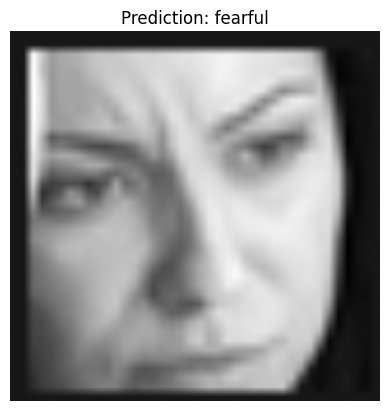

In [ ]:
cut_and_predict_image("/content/archive/test/neutral/im1009.png",last_model,train_data)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step


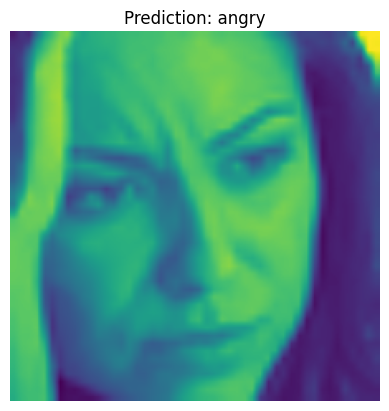

In [ ]:
pred_and_plot(last_model,"/content/archive/test/neutral/im1009.png",train_data.class_names)

In [ ]:
for img, label in train_data.take(1):
    print("Image shape:", img.shape)  # Should be (batch_size, 224, 224, 3)
    print("Label:", label.numpy())  # Should be one-hot encoded

Image shape: (32, 224, 224, 1)
Label: [[0. 0. 1. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0.]
 [0. 0. 1. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0.]
 [1. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0.]
 [0. 0. 1. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0.]
 [0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 1. 0.]
 [0. 0. 0. 1. 0. 0.]
 [1. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0.]
 [0. 1. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0.]
 [0. 0. 0. 1. 0. 0.]
 [0. 0. 0. 0. 0. 1.]
 [1. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0.]
 [0. 0. 1. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0.]]


In [ ]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.optimizers import AdamW

# Data Augmentation (works for grayscale)
data_augmentation = keras.Sequential([
  layers.RandomFlip("horizontal"),
  layers.RandomRotation(0.2),
  layers.RandomZoom(0.2),
  layers.RandomHeight(0.2),
  layers.RandomWidth(0.2),
  layers.Rescaling(1./255)  # Normalize images
], name="data_augmentation")

input_shape = (224, 224, 1)  # Grayscale input
base_model = tf.keras.applications.EfficientNetV2B3(include_top=False)
base_model.trainable = True

# Freeze fewer layers
for layer in base_model.layers[:-50]:
  layer.trainable = False

inputs = layers.Input(shape=(224, 224, 1), name="input_layer")
x = layers.Conv2D(3, (1, 1), activation=None)(inputs)  # Convert grayscale to RGB
x = base_model(x, training=False)
x = layers.GlobalAveragePooling2D(name="pooling_layer")(x)
x = layers.Dropout(0.5)(x)
x = layers.Dense(256, activation="relu")(x)
x = layers.Dropout(0.3)(x)
outputs = layers.Dense(len(train_data.class_names), activation="softmax")(x)  # Softmax here
model_2 = tf.keras.Model(inputs, outputs)

# Optimizer
optimizer = AdamW(learning_rate=1e-4, weight_decay=1e-4)
model_2.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

# Unfreeze model after 5 epochs
def unfreeze_model():
    base_model.trainable = True
    print("Unfreezing model!")

unfreeze_callback = tf.keras.callbacks.LambdaCallback(on_epoch_end=lambda epoch, logs: unfreeze_model() if epoch == 5 else None)

# Train model
history_2 = model_2.fit(train_data,
    epochs=25,
    validation_data=test_data,
    steps_per_epoch=len(train_data),
    validation_steps=int(0.25 * len(test_data)),
    callbacks=[early_stopping, lr_scheduler, unfreeze_callback])


Epoch 1/25
221/221 ━━━━━━━━━━━━━━━━━━━━ 228s 728ms/step - accuracy: 0.2829 - loss: 1.7111 - val_accuracy: 0.1456 - val_loss: 1.8289 - learning_rate: 1.0000e-04
Epoch 2/25
221/221 ━━━━━━━━━━━━━━━━━━━━ 169s 504ms/step - accuracy: 0.4515 - loss: 1.3999 - val_accuracy: 0.2483 - val_loss: 1.6370 - learning_rate: 1.0000e-04
Epoch 3/25
221/221 ━━━━━━━━━━━━━━━━━━━━ 142s 642ms/step - accuracy: 0.5038 - loss: 1.2733 - val_accuracy: 0.3147 - val_loss: 1.5052 - learning_rate: 1.0000e-04
Epoch 4/25
221/221 ━━━━━━━━━━━━━━━━━━━━ 142s 642ms/step - accuracy: 0.5261 - loss: 1.2019 - val_accuracy: 0.3638 - val_loss: 1.4398 - learning_rate: 1.0000e-04
Epoch 5/25
221/221 ━━━━━━━━━━━━━━━━━━━━ 142s 642ms/step - accuracy: 0.5553 - loss: 1.1494 - val_accuracy: 0.3761 - val_loss: 1.3998 - learning_rate: 1.0000e-04
Epoch 6/25
221/221 ━━━━━━━━━━━━━━━━━━━━ 0s 488ms/step - accuracy: 0.5758 - loss: 1.1023Unfreezing model!
221/221 ━━━━━━━━━━━━━━━━━━━━ 111s 502ms/step - accuracy: 0.5758 - loss: 1.1023 - val_accuracy: 

In [ ]:
from google.colab import files
import shutil
model_2.save("model_2.h5")
shutil.make_archive("model_2", 'zip', ".", "model_2.h5")
files.download("model_2.zip")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:

import cv2
import numpy as np
from tensorflow.keras.preprocessing import image

def preprocess_image(img_path):
    img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)  # Load as grayscale
    img = cv2.resize(img, (224, 224))  # Resize to match model input
    img = img.astype("float32") / 255.0  # Normalize pixel values (0-1)
    img = np.expand_dims(img, axis=-1)  # Add channel dimension (224, 224, 1)
    img = np.expand_dims(img, axis=0)  # Add batch dimension (1, 224, 224, 1)
    return img



def predict_image(img_path, model, class_names):
    processed_img = preprocess_image(img_path)
    predictions = model.predict(processed_img)
    predicted_class = np.argmax(predictions, axis=1)  # Get the class with highest probability
    confidence = np.max(predictions)  # Get confidence score
    return class_names[predicted_class[0]], confidence


class_names = train_data.class_names  # Replace with actual class names
img_path = "/content/archive/train/happy/im1090.png"

predicted_label, confidence = predict_image(img_path, last_model, class_names)
print(f"Predicted Label: {predicted_label} | Confidence: {confidence:.2f}")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
Predicted Label: angry | Confidence: 0.71


In [ ]:
import kagglehub

# Download latest version
path = kagglehub.model_download("makototsuneto/models-for-facial-expression-recognition/tensorFlow2/default")

print("Path to model files:", path)


100%|██████████| 55.0/55.0 [00:00<00:00, 88.7kB/s]



  0%|          | 0.00/19.9M [00:00<?, ?B/s]



100%|██████████| 56.0/56.0 [00:00<00:00, 174kB/s]




100%|██████████| 17.3k/17.3k [00:00<00:00, 14.9MB/s]




  0%|          | 0.00/267k [00:00<?, ?B/s]




  0%|          | 0.00/62.1k [00:00<?, ?B/s]





  0%|          | 0.00/557k [00:00<?, ?B/s]
  5%|▌         | 1.00M/19.9M [00:00<00:07, 2.63MB/s]






100%|██████████| 62.1k/62.1k [00:00<00:00, 1.03MB/s]





100%|██████████| 6.08k/6.08k [00:00<00:00, 17.7MB/s]

 15%|█▌        | 3.00M/19.9M [00:00<00:02, 7.35MB/s]

100%|██████████| 267k/267k [00:00<00:00, 1.07MB/s]

 45%|████▌     | 9.00M/19.9M [00:00<00:00, 21.2MB/s]



100%|██████████| 557k/557k [00:00<00:00, 1.76MB/s]




  0%|          | 0.00/2.08M [00:00<?, ?B/s]
 60%|██████    | 12.0M/19.9M [00:00<00:00, 20.1MB/s]




  4%|▍         | 1.00M/24.8M [00:00<00:09, 2.64MB/s]




100%|██████████| 3.26k/3.26k [00:00<00:00, 8.71MB/s]





  0%|          | 0.00/27.5M [00:00<?, ?B/s]





100%|██████████| 27.6k/27.6k [00:00<00:00, 10.9MB/s]





 12%|█▏        | 3.00M/24.8M [00:00<00:03, 7.26MB/s]




 36%|███▋      | 9.00M/24.8M [00:00<00:00, 21.1MB/s]
100%|██████████| 19.9M/19.9M [00:01<00:00, 18.7MB/s]



  0%|          | 0.00/296k [00:00<?, ?B/s]

 48%|████▊     | 1.00M/2.08M [00:00<00:00, 2.61MB/s]






 48%|████▊     | 12.0M/24.8M [00:00<00:00, 20.7MB/s]



  0%|          | 0.00/27.5M [00:00<?, ?B/s]







100%|██████████| 58.0/58.0 [00:00<00:00, 29.9kB/s]



100%|██████████| 2.08M/2.08M [00:00<00:00, 4.61MB/s]




100%|██████████| 3.26k/3.26k [00:00<00:00, 6.68MB/s]



 11%|█         | 3.00M/27.5M [00:00<00:03, 7.31MB/s]
100%|██████████| 296k/296k [00:00<00:00, 1.12MB/s]





 61%|██████    | 15.0M/24.8M [00:01<00:00, 16.6MB/s]


 29%|██▉       | 8.00M/27.5M [00:00<00:01, 19.4MB/s]


100%|██████████| 57.0/57.0 [00:00<00:00, 46.9kB/s]





 81%|████████  | 20.0M/24.8M [00:01<00:00, 23.7MB/s]


 47%|████▋     | 13.0M/27.5M [00:00<00:00, 28.0MB/s]



100%|██████████| 24.8M/24.8M [00:01<00:00, 21.5MB/s]



 66%|██████▌   | 18.0M/27.5M [00:00<00:00, 32.6MB/s]



 11%|█         | 3.00M/27.5M [00:00<00:03, 7.09MB/s]


 87%|████████▋ | 24.0M/27.5M [00:00<00:00, 40.0MB/s]



100%|██████████| 27.5M/27.5M [00:01<00:00, 27.9MB/s]




 47%|████▋     | 13.0M/27.5M [00:00<00:00, 25.7MB/s]


  0%|          | 0.00/297k [00:00<?, ?B/s]



100%|██████████| 27.6k/27.6k [00:00<00:00, 17.6MB/s]




 66%|██████▌   | 18.0M/27.5M [00:00<00:00, 32.4MB/s]



  0%|          | 0.00/19.2M [00:00<?, ?B/s]




100%|██████████| 1.90k/1.90k [00:00<00:00, 2.56MB/s]

100%|██████████| 297k/297k [00:00<00:00, 1.16MB/s]



100%|██████████| 55.0/55.0 [00:00<00:00, 210kB/s]



100%|██████████| 19.3k/19.3k [00:00<00:00, 39.2MB/s]




 80%|████████  | 22.0M/27.5M [00:01<00:00, 23.2MB/s]


  0%|          | 0.00/154k [00:00<?, ?B/s]



100%|██████████| 27.5M/27.5M [00:01<00:00, 22.8MB/s]


  5%|▌         | 1.00M/19.2M [00:00<00:07, 2.68MB/s]
100%|██████████| 154k/154k [00:00<00:00, 825kB/s]


 16%|█▌        | 3.00M/19.2M [00:00<00:02, 7.37MB/s]

 42%|████▏     | 8.00M/19.2M [00:00<00:00, 19.6MB/s]

 68%|██████▊   | 13.0M/19.2M [00:00<00:00, 27.2MB/s]

100%|██████████| 19.2M/19.2M [00:00<00:00, 23.8MB/s]

Path to model files: /root/.cache/kagglehub/models/makototsuneto/models-for-facial-expression-recognition/tensorFlow2/default/1


In [ ]:
import os

dataset_path = "/root/.cache/kagglehub/models/makototsuneto/models-for-facial-expression-recognition/tensorFlow2/default/1"

# List files in the dataset directory
files = os.listdir(dataset_path)
print("Dataset files:", files)

Dataset files: ['best_regularized_model', 'best_light_cnn_model', 'best_simple_model', 'best_regularized_model2', 'best_mobilenet_model']


In [ ]:
import shutil

destination = "/content/emotions_dataset"  # Change this path if needed
shutil.move(dataset_path, destination)

print("Dataset moved to:", destination)

Dataset moved to: /content/emotions_dataset


In [ ]:
import tensorflow as tf
def load_pb_model(pb_path):
    with tf.io.gfile.GFile(pb_path, "rb") as f:
        graph_def = tf.compat.v1.GraphDef()
        graph_def.ParseFromString(f.read())
    with tf.Graph().as_default() as graph:
        tf.import_graph_def(graph_def, name="")
    return graph
graph = load_pb_model("/content/emotions_dataset/best_mobilenet_model/fingerprint.pb")


In [ ]:
for op in graph.get_operations():
    print(op.name)


In [ ]:
# Convert grayscale images to RGB
def grayscale_to_rgb(x):
    return tf.image.grayscale_to_rgb(x)

# Data Augmentation
data_augmentation = Sequential([
    layers.Lambda(grayscale_to_rgb),  # Convert grayscale to RGB
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1),
    layers.RandomContrast(0.1)
], name="data_augmentation")

# Load Pretrained EfficientNetV2B3 (Fine-Tuning)
base_model = tf.keras.applications.EfficientNetV2B3(include_top=False, input_shape=(224, 224, 3))
base_model.trainable = False  # Freeze all layers initially

# Unfreeze last 30 layers for fine-tuning
for layer in base_model.layers[-30:]:
    layer.trainable = True

# Custom CNN Feature Extractor (Parallely Processing)
cnn_model = Sequential([
    layers.Conv2D(32, 3, padding="same", activation=None, input_shape=(224, 224, 1)),
    layers.BatchNormalization(),
    layers.ReLU(),
    layers.MaxPool2D(),

    layers.Conv2D(64, 3, padding="same", activation=None),
    layers.BatchNormalization(),
    layers.ReLU(),
    layers.MaxPool2D(),

    layers.Conv2D(128, 3, padding="same", activation=None),
    layers.BatchNormalization(),
    layers.ReLU(),
    layers.MaxPool2D(),

    layers.GlobalAveragePooling2D(),  # Convert to 1D for merging
])

# Model Inputs
inputs = layers.Input(shape=(224, 224, 1))
x = data_augmentation(inputs)  # Convert to RGB & Augment

# EfficientNet Path
efficient_output = base_model(x)  # Get feature maps from EfficientNet
efficient_output = layers.GlobalAveragePooling2D()(efficient_output)  # Convert to 1D

# CNN Path
cnn_output = cnn_model(inputs)  # Pass grayscale image to CNN

# Merge Both Feature Maps
merged = layers.Concatenate()([efficient_output, cnn_output])

# Dense Layers
x = layers.Dense(256, activation="relu", kernel_regularizer=regularizers.l2(0.01))(merged)
x = layers.Dropout(0.5)(x)

x = layers.Dense(128, activation="relu", kernel_regularizer=regularizers.l2(0.01))(x)
x = layers.Dropout(0.5)(x)

# Output Layer
outputs = layers.Dense(len(train_data.class_names), activation='softmax')(x)

# Create Model
model = tf.keras.Model(inputs, outputs)


In [ ]:
model_21.summary()

Model: "sequential_10"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ data_augmentation (Sequential)       │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ efficientnetv2-b3 (Functional)       │ (None, 7, 7, 1536)          │      12,930,622 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d_4           │ (None, 1536)                │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_21 (Dense)                     │ (None, 256)                 │         393,472 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_16 (Dropout)                 │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_22 (Dense)                     │ (None, 128)                 │          32,896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_17 (Dropout)                 │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_23 (Dense)                     │ (None, 7)                   │             903 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 17,589,309 (67.10 MB)

 Trainable params: 2,115,707 (8.07 MB)

 Non-trainable params: 11,242,186 (42.89 MB)

 Optimizer params: 4,231,416 (16.14 MB)

In [ ]:
optimizer = tf.keras.optimizers.Adam(learning_rate=0.00001)
model_21.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

history_21 = model_21.fit(x=train_data,
    epochs=50,
    validation_data=test_data,
    steps_per_epoch=len(train_data),
    validation_steps=int(0.25 *len(test_data)),
    callbacks=[early_stopping, lr_scheduler])

Epoch 1/50
898/898 ━━━━━━━━━━━━━━━━━━━━ 144s 135ms/step - accuracy: 0.6230 - loss: 1.1487 - val_accuracy: 0.4492 - val_loss: 1.5180 - learning_rate: 1.0000e-05
Epoch 2/50
898/898 ━━━━━━━━━━━━━━━━━━━━ 117s 130ms/step - accuracy: 0.6376 - loss: 1.1077 - val_accuracy: 0.4559 - val_loss: 1.4810 - learning_rate: 1.0000e-05
Epoch 3/50
898/898 ━━━━━━━━━━━━━━━━━━━━ 142s 130ms/step - accuracy: 0.6439 - loss: 1.0966 - val_accuracy: 0.4554 - val_loss: 1.4866 - learning_rate: 1.0000e-05
Epoch 4/50
898/898 ━━━━━━━━━━━━━━━━━━━━ 142s 130ms/step - accuracy: 0.6405 - loss: 1.0855 - val_accuracy: 0.4503 - val_loss: 1.4911 - learning_rate: 1.0000e-05
Epoch 5/50
898/898 ━━━━━━━━━━━━━━━━━━━━ 202s 197ms/step - accuracy: 0.6448 - loss: 1.0791 - val_accuracy: 0.4475 - val_loss: 1.4844 - learning_rate: 1.0000e-05
Epoch 6/50
898/898 ━━━━━━━━━━━━━━━━━━━━ 116s 130ms/step - accuracy: 0.6402 - loss: 1.0654 - val_accuracy: 0.4425 - val_loss: 1.4944 - learning_rate: 1.0000e-05
Epoch 7/50
898/898 ━━━━━━━━━━━━━━━━━━━━ 

In [ ]:
from google.colab import files
import shutil
model_21.save("model_image.h5")
shutil.make_archive("model_image", 'zip', ".", "model_image.h5")
files.download("model_image.zip")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
!pip install keras_cv

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 650.7/650.7 kB 18.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 950.8/950.8 kB 35.1 MB/s eta 0:00:00


In [ ]:
import tensorflow as tf
from tensorflow.keras import layers, Sequential, regularizers
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

early_stopping = EarlyStopping(monitor="val_loss", patience=5, restore_best_weights=True, verbose=1)
lr_reducer = ReduceLROnPlateau(monitor="val_loss", factor=0.3, patience=3, verbose=1)
lr_scheduler = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_accuracy', factor=0.5, patience=3, verbose=1)


input_shape = (224, 224, 1)
base_model = tf.keras.applications.EfficientNetV2B3(include_top=False)
base_model.trainable = True

for layer in base_model.layers[:-30]:
  layer.trainable = False
inputs = layers.Input(shape=input_shape, name="input_layer")
x = data_augmentation(inputs) # augment our training images
x = base_model(inputs, training=False)
x = layers.GlobalAveragePooling2D(name="pooling_layer")(x)
x = layers.Dropout(0.5)(x)  # Add dropout to reduce overfitting
x = layers.Dense(256, activation="relu")(x)
x = layers.Dropout(0.3)(x)  # Add another dropout layer
x = layers.Dense(len(train_data.class_names))(x)
outputs = layers.Activation("softmax", dtype=tf.float32, name="softmax_float32")(x)
model_23 = tf.keras.Model(inputs, outputs)

model_23.compile(loss="categorical_crossentropy",
              optimizer=tf.keras.optimizers.Adam(0.0001),
              metrics=["accuracy"])
history_23 = model_23.fit(train_data,
                          epochs=50,
                          steps_per_epoch=len(train_data),
                          validation_data=test_data,
                          validation_steps=int(0.25*len(test_data)),
                          callbacks=[early_stopping, lr_scheduler])


Epoch 1/50
898/898 ━━━━━━━━━━━━━━━━━━━━ 140s 104ms/step - accuracy: 0.3584 - loss: 1.6506 - val_accuracy: 0.2282 - val_loss: 1.7795 - learning_rate: 1.0000e-04
Epoch 2/50
898/898 ━━━━━━━━━━━━━━━━━━━━ 137s 127ms/step - accuracy: 0.5193 - loss: 1.2707 - val_accuracy: 0.3700 - val_loss: 1.5176 - learning_rate: 1.0000e-04
Epoch 3/50
898/898 ━━━━━━━━━━━━━━━━━━━━ 90s 69ms/step - accuracy: 0.5547 - loss: 1.1805 - val_accuracy: 0.3934 - val_loss: 1.4494 - learning_rate: 1.0000e-04
Epoch 4/50
898/898 ━━━━━━━━━━━━━━━━━━━━ 82s 69ms/step - accuracy: 0.5801 - loss: 1.1180 - val_accuracy: 0.4269 - val_loss: 1.4137 - learning_rate: 1.0000e-04
Epoch 5/50
898/898 ━━━━━━━━━━━━━━━━━━━━ 62s 69ms/step - accuracy: 0.5945 - loss: 1.0762 - val_accuracy: 0.4420 - val_loss: 1.4103 - learning_rate: 1.0000e-04
Epoch 6/50
898/898 ━━━━━━━━━━━━━━━━━━━━ 82s 91ms/step - accuracy: 0.6091 - loss: 1.0377 - val_accuracy: 0.4436 - val_loss: 1.4156 - learning_rate: 1.0000e-04
Epoch 7/50
898/898 ━━━━━━━━━━━━━━━━━━━━ 62s 69ms

In [ ]:
model_23.evaluate(test_data)

225/225 ━━━━━━━━━━━━━━━━━━━━ 19s 84ms/step - accuracy: 0.6502 - loss: 1.0077


[0.9217474460601807, 0.6779047250747681]

In [ ]:
from google.colab import files
import shutil
model_23.save("model_image.h5")
shutil.make_archive("model_image", 'zip', ".", "model_image.h5")
files.download("model_image.zip")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step


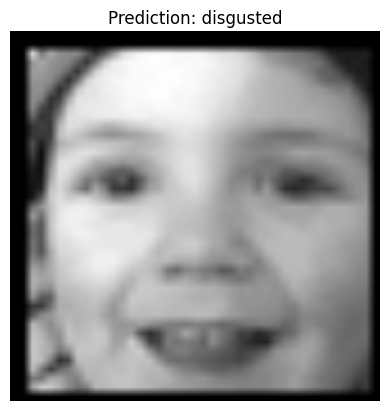

In [ ]:
cut_and_predict_image("/content/train/happy/im1055.png", model_23, train_data)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step


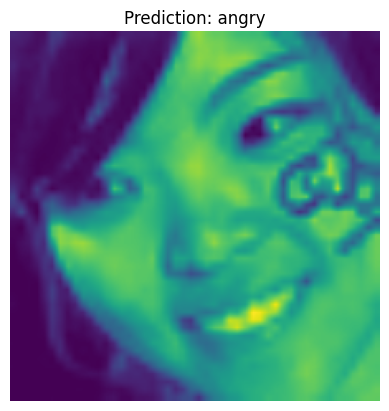

In [ ]:
from helper_functions import pred_and_plot
pred_and_plot( model_23,"/content/train/happy/im106.png", train_data.class_names)

In [ ]:
import tensorflow as tf
last_model = unzip_data("/content/model_image (1).zip")

In [ ]:
last_model = tf.keras.models.load_model('/content/model_image.h5')


In [ ]:
last_model.summary()

Model: "functional_11"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 224, 224, 1)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ efficientnetv2-b3 (Functional)       │ (None, 7, 7, 1536)          │      12,930,622 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ pooling_layer                        │ (None, 1536)                │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_29 (Dropout)                 │ (None, 1536)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_37 (Dense)                     │ (None, 256)                 │         393,472 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_30 (Dropout)                 │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_38 (Dense)                     │ (None, 7)                   │           1,799 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ softmax_float32 (Activation)         │ (None, 7)                   │               0 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 13,325,895 (50.83 MB)

 Trainable params: 2,083,707 (7.95 MB)

 Non-trainable params: 11,242,186 (42.89 MB)

 Optimizer params: 2 (12.00 B)

In [ ]:
import tensorflow as tf
import numpy as np
from tensorflow.keras.preprocessing import image

# Load the image
def load_and_preprocess_image(image_path):
    img = image.load_img(image_path, target_size=(224, 224), color_mode="grayscale")  # Match input shape
    img_array = image.img_to_array(img)  # Convert to array
    img_array = np.expand_dims(img_array, axis=0)  # Expand dimensions to match model input
    img_array = img_array / 255.0  # Normalize (if your training images were normalized)
    return img_array
# Path to your image
image_path = "/content/ian-dooley-d1UPkiFd04A-unsplash.jpg"

# Preprocess the image
img_array = load_and_preprocess_image(image_path)

# Predict
predictions = last_model.predict(img_array)

# Get the class with highest probability
predicted_class = np.argmax(predictions, axis=1)[0]

# Get the class label
class_labels = train_data.class_names  # Assuming `train_data.class_names` exists
predicted_label = class_labels[predicted_class]

print(f"Predicted Class: {predicted_label} ({predicted_class})")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
Predicted Class: angry (0)


## new data set


In [7]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("sujaykapadnis/emotion-recognition-dataset")

print("Path to dataset files:", path)

100%|██████████| 1.98G/1.98G [00:23<00:00, 92.4MB/s]

Extracting files...


Path to dataset files: /root/.cache/kagglehub/datasets/sujaykapadnis/emotion-recognition-dataset/versions/1


In [10]:
import shutil

source_path = "/root/.cache/kagglehub/datasets/sujaykapadnis/emotion-recognition-dataset/versions/1"
destination_path = "/content/emotion-recognition-dataset"

shutil.move(source_path, destination_path)

print("Dataset moved to:", destination_path)
print("Contents:", os.listdir(destination_path))


Dataset moved to: /content/emotion-recognition-dataset
Contents: ['dataset', 'data.csv']


In [11]:
from tensorflow.keras.preprocessing import image_dataset_from_directory

train_dir = "/content/emotion-recognition-dataset/dataset"
IMG_SIZE = (224, 224)
BATCH_SIZE = 32  # You can adjust this

# Load Training Data (90%) and Test Data (10%)
train_data = image_dataset_from_directory(
    train_dir,
    label_mode='categorical',
    image_size=IMG_SIZE,
    validation_split=0.1,  # 10% for test
    subset="training",  # Training split
    seed=123,  # Ensure consistent split
    batch_size=BATCH_SIZE
)

test_data = image_dataset_from_directory(
    train_dir,
    label_mode='categorical',
    image_size=IMG_SIZE,
    validation_split=0.1,  # 10% for test
    subset="validation",  # Test split
    seed=123,
    batch_size=BATCH_SIZE
)


Found 15453 files belonging to 6 classes.
Using 13908 files for training.
Found 15453 files belonging to 6 classes.
Using 1545 files for validation.


In [ ]:
#check the imbalance
import os
from collections import Counter

class_counts = {}

for class_name in os.listdir(train_dir):
    class_path = os.path.join(train_dir, class_name)
    if os.path.isdir(class_path):
        class_counts[class_name] = len(os.listdir(class_path))

print("Class Distribution:", class_counts)


Class Distribution: {'Neutral': 4027, 'Happy': 3740, 'Angry': 1313, 'Sad': 3934, 'Surprise': 1234, 'Ahegao': 1205}


In [63]:
from sklearn.utils.class_weight import compute_class_weight
import numpy as np

# Define your class names and their respective counts
class_counts = {'Angry': 1313, 'Ahegao': 1205, 'Happy': 3740, 'Surprise': 1234, 'Neutral': 4027, 'Sad': 3934}

# Extract labels and counts
class_labels = np.array(list(class_counts.keys()))
class_samples = np.array(list(class_counts.values()))

# Compute class weights
class_weights = compute_class_weight(
    class_weight="balanced",
    classes=np.arange(len(class_labels)),
    y=np.repeat(np.arange(len(class_labels)), class_samples)
)

# Convert to dictionary format for model training
class_weight_dict = {i: class_weights[i] for i in range(len(class_weights))}

print("Computed Class Weights:", class_weight_dict)


Computed Class Weights: {0: np.float64(1.9615384615384615), 1: np.float64(2.137344398340249), 2: np.float64(0.6886363636363636), 3: np.float64(2.0871150729335493), 4: np.float64(0.6395579836106282), 5: np.float64(0.6546771733604474)}


In [14]:
import tensorflow as tf
from tensorflow.keras import layers, Sequential, regularizers
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

# Callbacks
early_stopping = EarlyStopping(monitor="val_loss", patience=5, restore_best_weights=True, verbose=1)
lr_scheduler = ReduceLROnPlateau(monitor="val_accuracy", factor=0.5, patience=3, verbose=1)

# Model Architecture
input_shape = (224, 224, 3)
base_model = tf.keras.applications.EfficientNetV2B3(include_top=False)
base_model.trainable = True

# Unfreeze More Layers for Better Feature Learning
for layer in base_model.layers[:-70]:
    layer.trainable = False

inputs = layers.Input(shape=input_shape, name="input_layer")
x = data_augmentation(inputs)  # Data Augmentation
x = base_model(x, training=False)
x = layers.GlobalAveragePooling2D(name="pooling_layer")(x)
x = layers.Dropout(0.5)(x)  # Reduce overfitting

# Add Dense Layers with L2 Regularization
x = layers.Dense(256, kernel_regularizer=regularizers.l2(0.01))(x)
x = layers.BatchNormalization()(x)
x = layers.Activation("relu")(x)
x = layers.Dropout(0.3)(x)  # Additional dropout
x = layers.Dense(len(train_data.class_names))(x)
outputs = layers.Activation("softmax", dtype=tf.float32, name="softmax_float32")(x)

# Compile Model
model_24 = tf.keras.Model(inputs, outputs)
model_24.compile(
    loss="categorical_crossentropy",
    optimizer=tf.keras.optimizers.Adam(0.0001),
    metrics=["accuracy"]
)

# Train Model with Class Weights
history_24 = model_24.fit(
    train_data,
    epochs=100,
    steps_per_epoch=len(train_data),
    validation_data=test_data,
    validation_steps=int(0.25 * len(test_data)),
    callbacks=[early_stopping, lr_scheduler]
)


Epoch 1/100
435/435 ━━━━━━━━━━━━━━━━━━━━ 104s 175ms/step - accuracy: 0.3467 - loss: 5.8895 - val_accuracy: 0.6302 - val_loss: 4.5245 - learning_rate: 1.0000e-04
Epoch 2/100
435/435 ━━━━━━━━━━━━━━━━━━━━ 71s 164ms/step - accuracy: 0.5693 - loss: 4.4567 - val_accuracy: 0.6693 - val_loss: 3.5979 - learning_rate: 1.0000e-04
Epoch 3/100
435/435 ━━━━━━━━━━━━━━━━━━━━ 82s 164ms/step - accuracy: 0.6315 - loss: 3.5976 - val_accuracy: 0.6797 - val_loss: 2.9155 - learning_rate: 1.0000e-04
Epoch 4/100
435/435 ━━━━━━━━━━━━━━━━━━━━ 81s 163ms/step - accuracy: 0.6531 - loss: 2.9303 - val_accuracy: 0.7422 - val_loss: 2.3699 - learning_rate: 1.0000e-04
Epoch 5/100
435/435 ━━━━━━━━━━━━━━━━━━━━ 83s 190ms/step - accuracy: 0.6743 - loss: 2.3932 - val_accuracy: 0.7734 - val_loss: 1.9116 - learning_rate: 1.0000e-04
Epoch 6/100
435/435 ━━━━━━━━━━━━━━━━━━━━ 71s 162ms/step - accuracy: 0.6972 - loss: 1.9879 - val_accuracy: 0.7630 - val_loss: 1.5899 - learning_rate: 1.0000e-04
Epoch 7/100
435/435 ━━━━━━━━━━━━━━━━━━━

In [15]:
from google.colab import files
import shutil
model_24.save("model_final_image_2.keras")
shutil.make_archive("model_final_image_2", 'zip', ".", "model_final_image_2.keras")
files.download("model_final_image_2.zip")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [57]:
import os
import random
import cv2
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

# Load the face detection model
faceCascade = cv2.CascadeClassifier(cv2.data.haarcascades + "haarcascade_frontalface_default.xml")

def load_and_preprocess_image(image_path):
    """Load and preprocess an image in RGB format using OpenCV."""
    if not isinstance(image_path, str):
        print("Error: image_path is not a string.")
        return None, None

    img = cv2.imread(image_path, cv2.IMREAD_COLOR)  # Read in color (BGR)

    if img is None:
        print(f"Error: Could not load image {image_path}. Check the file path.")
        return None, None

    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # Convert BGR to RGB
    img_resized = cv2.resize(img, (224, 224))  # Resize to match model input

    img_array = np.expand_dims(img_resized, axis=0)  # Add batch dimension
    img_array = img_array / 255.0  # Normalize pixel values

    return img, img_array  # Return original and processed image

def detect_and_predict_multiple(train_data, model, num_samples=5):
    """Select multiple random images, predict emotions, and display results."""

    all_images = []  # Store (image_path, true_label) pairs
    base_dir = "/content/emotion-recognition-dataset/dataset/"  # Adjust to your dataset path

    # Collect image paths and labels
    for class_name in train_data.class_names:
        class_path = os.path.join(base_dir, class_name)
        if os.path.exists(class_path):
            image_files = os.listdir(class_path)
            image_paths = [os.path.join(class_path, img) for img in image_files]
            all_images.extend([(img_path, class_name) for img_path in image_paths])

    # Select random images
    random_samples = random.sample(all_images, min(num_samples, len(all_images)))

    plt.figure(figsize=(10, 10))

    for i, (image_path, true_label) in enumerate(random_samples):
        # Load and preprocess image
        original_img, processed_img = load_and_preprocess_image(image_path)
        if original_img is None:
            continue

        # Predict using the model
        prediction = model.predict(processed_img)
        predicted_class = train_data.class_names[np.argmax(prediction[0])]

        # Display image with labels
        plt.subplot(1, num_samples, i + 1)
        plt.imshow(original_img)
        plt.title(f"Pred: {predicted_class}\nTrue: {true_label}", color="green" if predicted_class == true_label else "red")
        plt.axis("off")

    plt.tight_layout()
    plt.show()


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


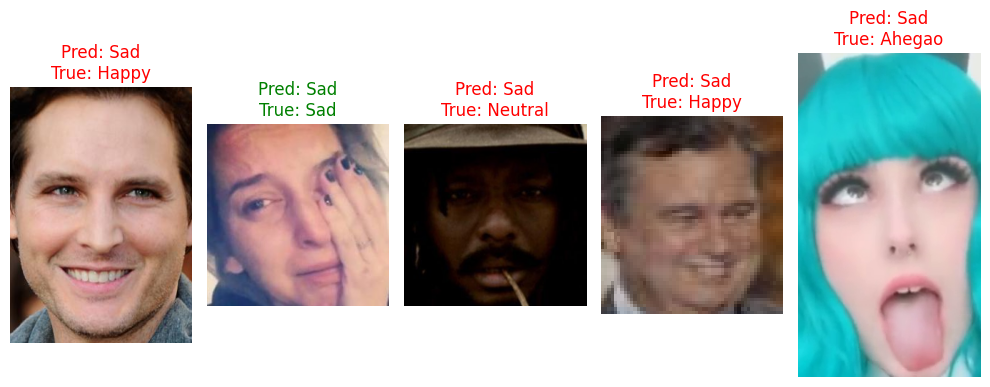

In [62]:
detect_and_predict_multiple(train_data,model_24)

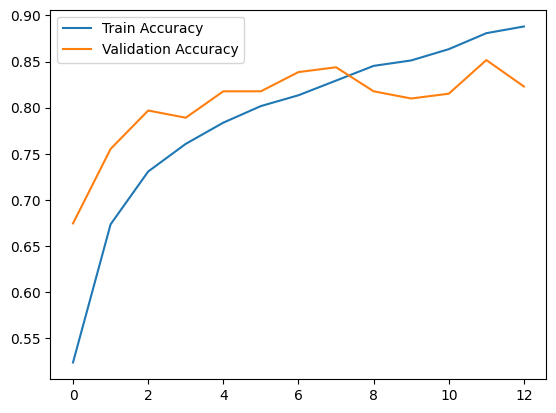

In [ ]:
import tensorflow as tf
from tensorflow.keras import layers, Sequential, regularizers
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

# Callbacks
early_stopping = EarlyStopping(monitor="val_loss", patience=5, restore_best_weights=True, verbose=1)
lr_scheduler = ReduceLROnPlateau(monitor="val_accuracy", factor=0.5, patience=3, verbose=1)

# Model Architecture
input_shape = (224, 224, 3)
base_model = tf.keras.applications.EfficientNetV2B3(include_top=False)
base_model.trainable = True

# Unfreeze More Layers for Better Feature Learning
for layer in base_model.layers[:-100]:
    layer.trainable = False

inputs = layers.Input(shape=input_shape, name="input_layer")
x = data_augmentation(inputs)  # Data Augmentation
x = base_model(x, training=False)
x = layers.GlobalAveragePooling2D(name="pooling_layer")(x)
x = layers.Dropout(0.5)(x)  # Reduce overfitting

# Add Dense Layers with L2 Regularization
x = layers.Dense(256, kernel_regularizer=regularizers.l2(0.01))(x)
x = layers.BatchNormalization()(x)
x = layers.Activation("relu")(x)
x = layers.Dropout(0.3)(x)  # Additional dropout
x = layers.Dense(len(train_data.class_names))(x)
outputs = layers.Activation("softmax", dtype=tf.float32, name="softmax_float32")(x)

# Compile Model
model_25 = tf.keras.Model(inputs, outputs)
model_25.compile(
    loss="categorical_crossentropy",
    optimizer=tf.keras.optimizers.Adam(0.0001),
    metrics=["accuracy"]
)

# Train Model with Class Weights
history_25 = model_25.fit(
    train_data,
    epochs=100,
    steps_per_epoch=len(train_data),
    validation_data=test_data,
    class_weight=class_weight_dict,
    validation_steps=int(0.25 * len(test_data)),
    callbacks=[early_stopping, lr_scheduler]
)


Epoch 1/100
435/435 ━━━━━━━━━━━━━━━━━━━━ 120s 201ms/step - accuracy: 0.3441 - loss: 6.1446 - val_accuracy: 0.5911 - val_loss: 4.7573 - learning_rate: 1.0000e-04
Epoch 2/100
435/435 ━━━━━━━━━━━━━━━━━━━━ 81s 186ms/step - accuracy: 0.5417 - loss: 4.7471 - val_accuracy: 0.6536 - val_loss: 3.9201 - learning_rate: 1.0000e-04
Epoch 3/100
102/435 ━━━━━━━━━━━━━━━━━━━━ 1:01 183ms/step - accuracy: 0.6004 - loss: 4.0701